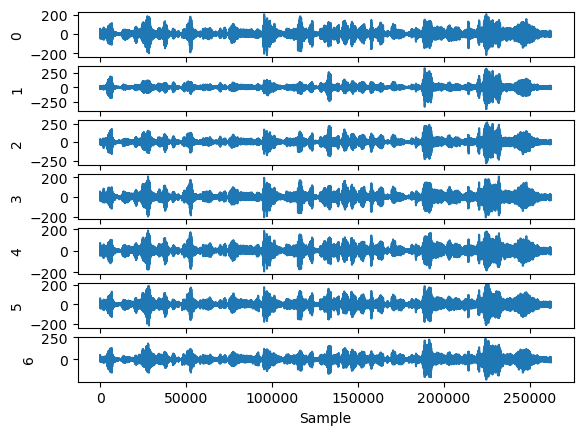

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft
from scipy.io import wavfile as wav

data = np.load('../uma8_sampling/data.npy')

fs = 48000
n_channels = 7
data = data[:, :n_channels]

# plot each channel
plt.subplot(n_channels, 1, 1)
for i_channel in range(n_channels):
    plt.subplot(n_channels, 1, i_channel+1)
    plt.plot((1 << 15)*data[:, i_channel])
    plt.ylabel(f'{i_channel}')
plt.xlabel('Sample')
plt.show()

In [32]:
c = 343
X = np.array([ # estimated positions of the microphones
    [0, 0],
    [0, 0.045],
    [0.039, 0.023],
    [0.039, -0.023],
    [0, -0.045],
    [-0.039, -0.023],
    [-0.039, 0.023],
])
# target_dir = np.array([-0.615, -0.788]) # intervening direction was about this way
target_dir = np.array([1, 0]) # target was about this way (direction of USB port)

delay = (fs/c)*X@target_dir+8

list(zip(X, delay))

[(array([0., 0.]), 8.0),
 (array([0.   , 0.045]), 8.0),
 (array([0.039, 0.023]), 13.457725947521865),
 (array([ 0.039, -0.023]), 13.457725947521865),
 (array([ 0.   , -0.045]), 8.0),
 (array([-0.039, -0.023]), 2.5422740524781338),
 (array([-0.039,  0.023]), 2.5422740524781338)]

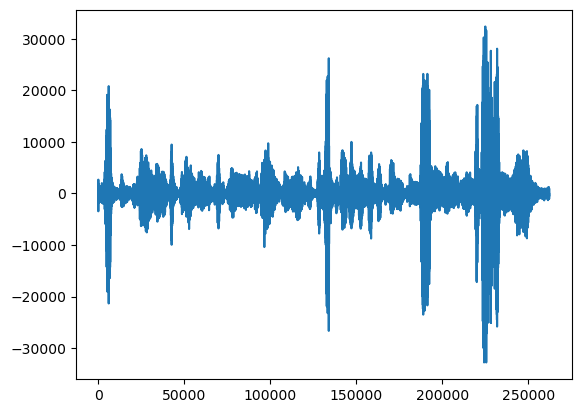

In [33]:
# roll each channel
Omega = np.arange(-np.pi, np.pi, 2*np.pi/len(data))
for i_channel in range(n_channels):
    f_data = fft(data[:, i_channel])
    f_data = np.exp(-1j*Omega*delay[i_channel])*f_data
    data[:, i_channel] = np.real(ifft(f_data))
    # data[:, i_channel] = np.roll(data[:, i_channel], rounded_delay[i_channel])

# sum each channel and normalize the result
final = np.sum(data, axis=1)
final = final/np.max(np.abs(final))

# plot the final signal
plt.plot((1 << 15)*final)
plt.show()

In [34]:
# export the final signal
wav.write('uma8_fracdelay_recovery_final.wav', fs, ((1 << 15)*final).astype(np.int16))

In [35]:
# export the original signals too
for i_channel in range(n_channels):
    normed_channel = data[:, i_channel]/np.max(np.abs(data[:, i_channel]))
    wav.write(f'uma8_fracdelay_recovery_{i_channel}.wav', fs, ((1 << 15)*normed_channel).astype(np.int16))